## Summary

The goal of the experiment is to use K-Nearest Neighbor for character recognition. Images for characters have already been segmented and labeled by type(character).  

We experimented K-NN with Euclidean, Manhattan, Chebyshev and Minkowski distances. The best accuracy so far is 0.733 by running distance-weighted K-NN on sharpened images, with neighbor amount set to 1 and the distance metric set to Euclidean/Minkowski.  
K-NN has a mean accuracy score up to 0.97 when running cross validation on the train set , but the best accuracy on the test set is no greater than 0.75. Overfitting potentially happens, that is, the test set has data which never appears in the given train set. To get a better learning model, we suspect that extracting image features as data can be better than directly comparing pixels. Since pixels do not consider font size, shearing and so on.  

PCA dimensionality reduction could sufficiently reduce the learning time spent, however, at the same time, decrease the prediction accuracy.  

Train set amount can impact K-NN results. On images that haven't been downscaled, the more samples we have in the train set, the better the accuracy we can get.  

On the same image data set, Euclidean and Minkowski behave the same. Manhattan behaves better on downscaled images Chebyshev has the worst performances. One of the reasons may be that Chebyshev is used to detect similarity between images on extracted features, rather than directly comparing pixels.  

For expansion, we also test distance-weighted K-Nearest Neighbor Regression with Gaussian kernel as the base function. Best result is K-nearest neighbors regression with Gaussian sigma = 1/16, neighbor amount k=25. The R2 score under this situation reaches about 0.65. So, the model's interpretability is not good enough. This might be improved by changing the base function for getting weights from distance; Or, this data model is not suitable to be processed by K-nearest neighbors regression.


In [1]:
import os
import time
import random
import math
from functools import partial
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import Isomap
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, SCORERS
from sklearn.preprocessing import normalize

from PIL import Image, ImageOps, ImageFilter
from matplotlib import pyplot as plt

## 1. Data Read

### 1.1 Read Image Data

In [2]:
train_data_path = "./data/train"
test_data_path = "./data/test"

def read_data(data_path):
    x = []
    y = []
    
    labels = os.listdir(data_path)
    # labels origianlly looks like: ['.DS_Store', '0', '1', '10', '11', '12', '13',..]
    labels.pop(0)
    
    # Now access each labelled folder and read images within it as np.array
    for label in labels:
        label_data_path = os.path.join(data_path, label)
        image_file_names = os.listdir(label_data_path)
        for file_name in image_file_names:
            img = Image.open(os.path.join(label_data_path, file_name))
            # make sure image is grayscale
            img = ImageOps.grayscale(img)
            pixels = np.array(img)
            
            # add pixels and associated labels to collection
            x.append(pixels)
            y.append(label)
    return x, y
               
raw_train_x, raw_train_y = read_data(train_data_path)
raw_test_x, raw_test_y = read_data(test_data_path)

### 1.2 Construct Train Data Set

By constructing the train information into dataframe, we could randomize it.

In [3]:
raw_train_data = {
    "image": raw_train_x,
    "label": raw_train_y,
}

train_df = pd.DataFrame(raw_train_data)
# shuffling data
train_df = train_df.sample(frac=1).reset_index(drop=True)
display(train_df)

,image,label
0,"[[0, 4, 1, 0, 0, 255, 252, 255, 255, 255, 255,...",33
1,"[[0, 0, 0, 3, 0, 0, 1, 1, 0, 1, 0, 190, 250, 2...",4
2,"[[0, 1, 3, 1, 30, 255, 255, 254, 252, 255, 249...",5
3,"[[0, 2, 1, 0, 1, 48, 251, 114, 2, 0, 1, 3, 15,...",22
4,"[[0, 1, 0, 0, 1, 0, 2, 0, 0, 16, 83, 135, 0, 0...",6
...,...,...
15949,"[[1, 0, 4, 1, 251, 252, 255, 255, 255, 251, 25...",5
15950,"[[1, 2, 1, 4, 0, 1, 1, 0, 0, 255, 255, 255, 1,...",10
15951,"[[1, 0, 0, 2, 0, 0, 0, 2, 3, 190, 255, 255, 0,...",10
15952,"[[0, 2, 0, 1, 0, 4, 17, 20, 20, 115, 122, 19, ...",8


## 2. Image Processing and Dimension Reduction

### 2.1 Image Preprocessing for Lighter Calculation

ref: https://stackoverflow.com/questions/56278307/using-pil-pillow-and-image-but-keeping-a-good-resolution  

The logic behind this is:  
Our source images are mostly at size (20, 20), so roughly 400 pixels with greyscale information.  
By reducing the image size, we could lower the calculation weight and time spent for calculating distance in Knn.  
However, image crisp(edges) cannot be maintained after size reduction. We will need to add a filter on top of the resizing.  

In [8]:
filters = [Image.NEAREST, Image.BILINEAR, Image.BICUBIC, Image.LANCZOS ]

# randomly take 10 images from train set as examples for testing filters
examples_df = train_df.sample(n=10, axis="rows")
# construct image from numpy array
images_np = list(examples_df["image"].values)

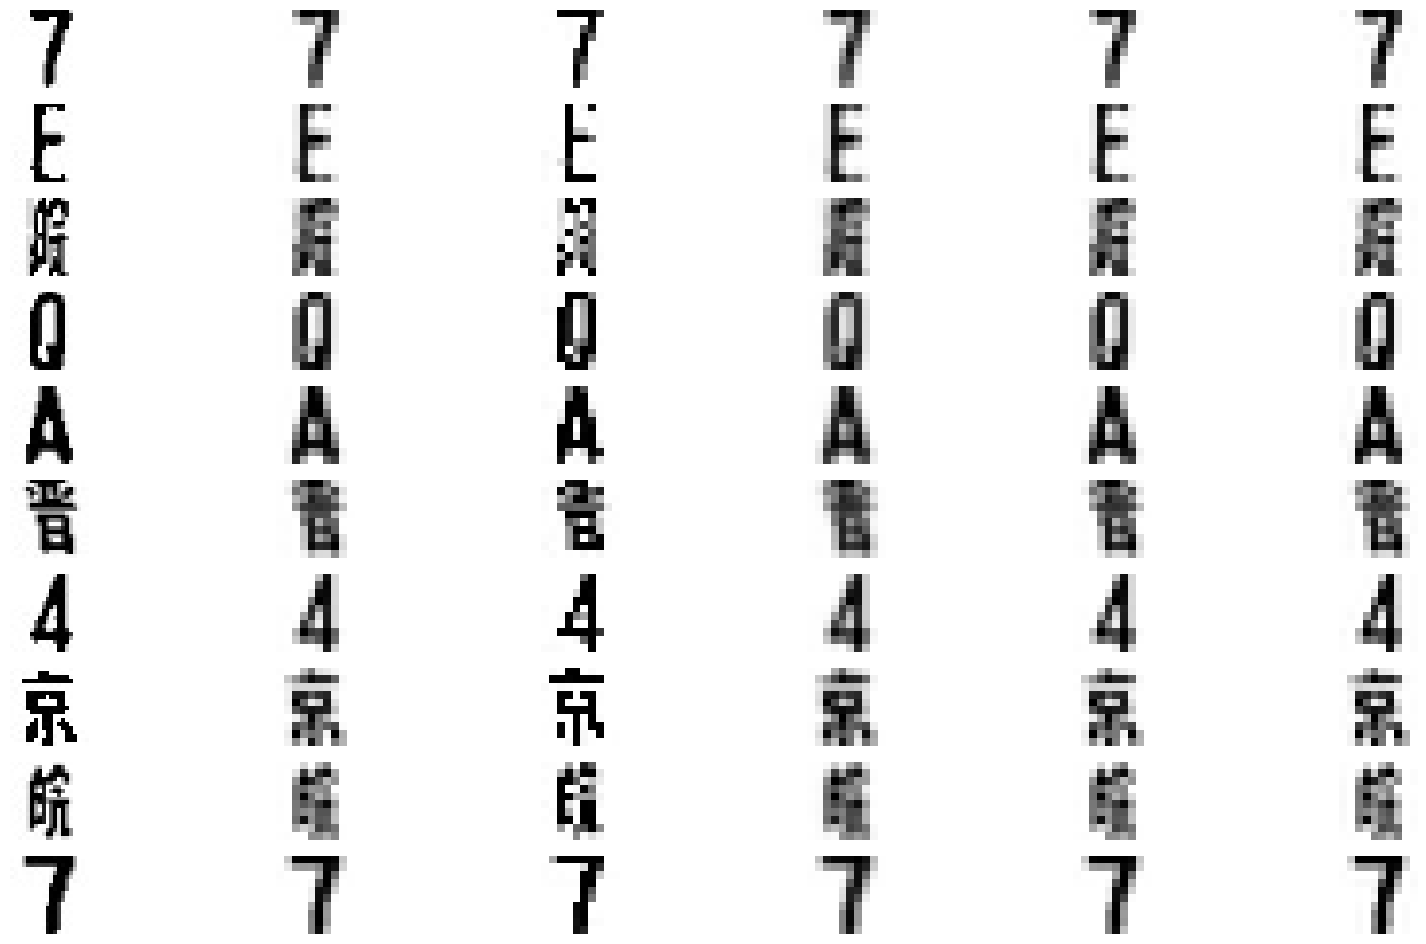

In [9]:
# create plt figure to display images
fig = plt.figure(figsize=(20, 12))
rows = 10
columns = 6
    
for i in range(0, len(images_np)):
    # get the image
    img = Image.fromarray(images_np[i]).convert("L")
    img = ImageOps.invert(img)
    # add subplot for original image
    fig.add_subplot(rows, columns, i*6+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("")
    
    # resize image without any filter
    resize_img = img.resize((10, 10))
    fig.add_subplot(rows, columns, i*6+2)
    plt.imshow(resize_img, cmap='gray')
    plt.axis('off')
    plt.title("")
    
    j = 1
    for filter in filters:
        new_img = img.resize((10, 10), filter)
        fig.add_subplot(rows, columns, i*6+2+j)
        plt.imshow(new_img, cmap='gray')
        plt.axis('off')
        plt.title("")
        j += 1
    

The first column are raw images, second are resized images without any filters.  
From column 3-6, they are resized images with nearest, bilinear, bicubic and lanczos filters.  

As the image above shows, even with filters, shapes are comparatively blur after resizing. Thus, we will try sharpening and noise reducing first on raw images, then resize.

### 2.2 Image Sharpening and Noise Reduction

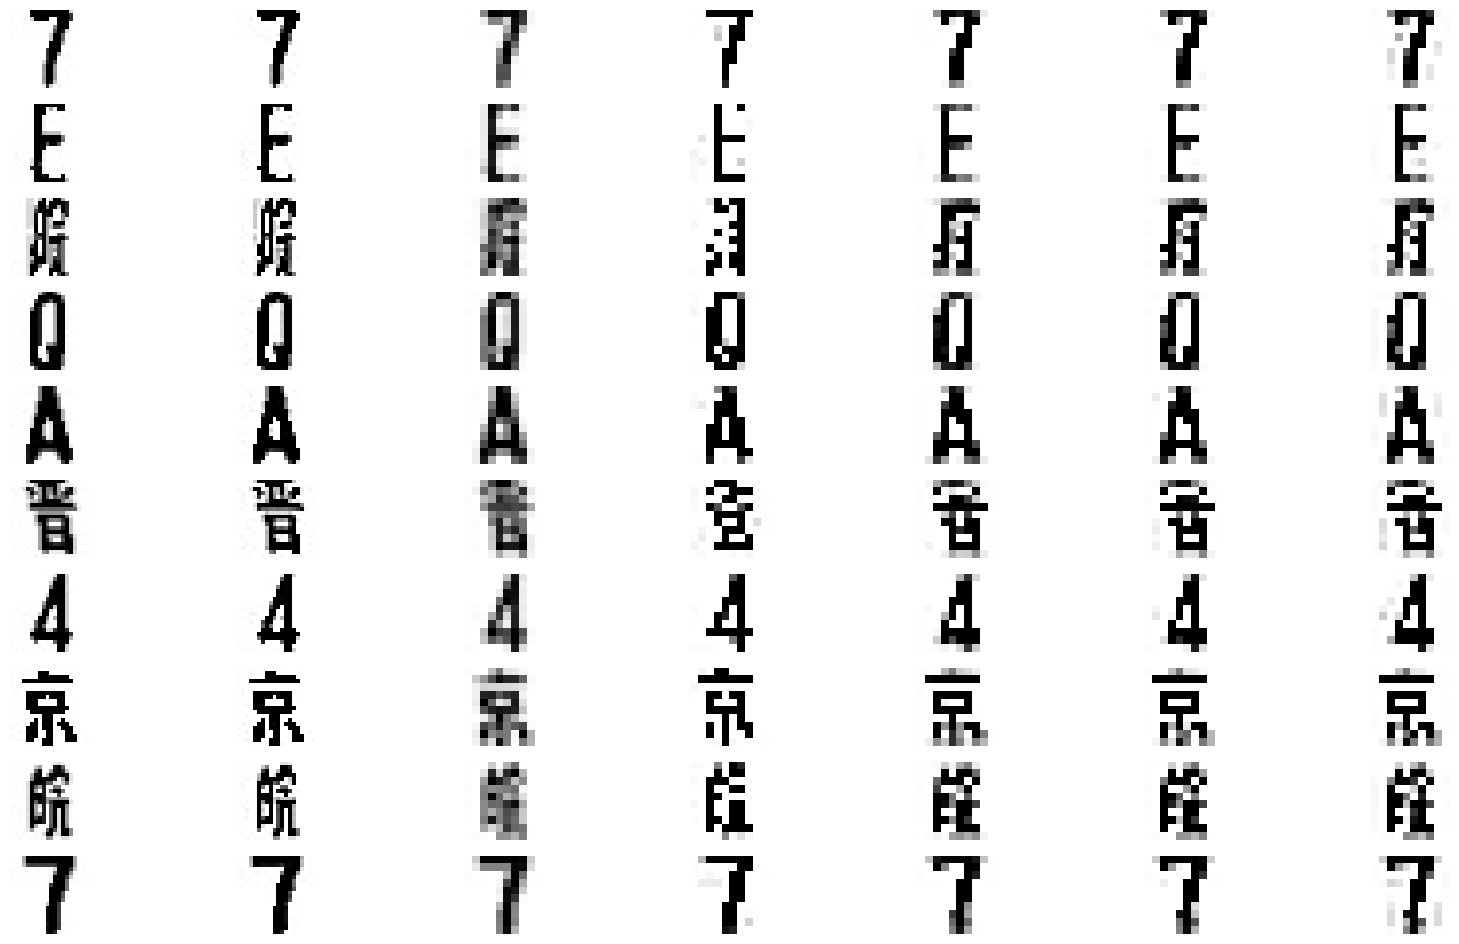

In [10]:
# create plt figure to display images
fig = plt.figure(figsize=(20, 12))
rows = 10
columns = 7

for i in range(0, len(images_np)):
    # get the image
    img = Image.fromarray(images_np[i]).convert("L")
    img = ImageOps.invert(img)
    # add subplot for original image
    fig.add_subplot(rows, columns, i*7+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("")
    
    # image sharpening
    sharpened_img = img.filter(ImageFilter.SHARPEN)
    fig.add_subplot(rows, columns, i*7+2)
    plt.imshow(sharpened_img, cmap='gray')
    plt.axis('off')
    plt.title("")
    
    # resize image without any filter
    resize_img = sharpened_img.resize((10, 10))
    fig.add_subplot(rows, columns, i*7+3)
    plt.imshow(resize_img, cmap='gray')
    plt.axis('off')
    plt.title("")
    
    j = 1
    for filter in filters:
        new_img = sharpened_img.resize((10, 10), filter)
        new_img = new_img.filter(ImageFilter.EDGE_ENHANCE_MORE)
        fig.add_subplot(rows, columns, i*7+3+j)
        plt.imshow(new_img, cmap='gray')
        plt.axis('off')
        plt.title("")
        j += 1
    

After compare and contrast, we could use column 2(sharpen) and column 5(sharpen+resize+bilinear filter) for later testing.  
Although edges with nearest filter may be more crisp, however, many small details(we are not sure if it is main structures) are lost.  
Following this, we will construct two train sets for testing in the next section.

### 2.3 Train Set Construction with Processed Images

In [7]:
def data_from_processed_image(data_path, sharpen=False, resize=False):
    x = []
    y = []
    
    labels = os.listdir(data_path)
    # labels origianlly looks like: ['.DS_Store', '0', '1', '10', '11', '12', '13',..]
    labels.pop(0)
    
    if resize:
        sharpen = True
    
    # Now access each labelled folder and read images within it as np.array
    for label in labels:
        label_data_path = os.path.join(data_path, label)
        image_file_names = os.listdir(label_data_path)
        for file_name in image_file_names:
            img = Image.open(os.path.join(label_data_path, file_name))
            img = ImageOps.invert(img)
            # make sure image is grayscale
            img = ImageOps.grayscale(img)
            # image sharpening
            if sharpen:
                img = img.filter(ImageFilter.SHARPEN)
            if resize:
                img = img.resize((10, 10), Image.BILINEAR)

            pixels = np.array(img).flatten()

            # add pixels and associated labels to collection
            x.append(pixels)
            y.append(label)
    return x, y

In [8]:
raw_train_x, raw_train_y = data_from_processed_image(train_data_path)
raw_test_x, raw_test_y = data_from_processed_image(test_data_path)

sharpen_train_x, sharpen_train_y = data_from_processed_image(train_data_path, sharpen=True)
sharpen_test_x, sharpen_test_y = data_from_processed_image(test_data_path, sharpen=True)

resize_train_x, resize_train_y = data_from_processed_image(train_data_path, resize=True)
resize_test_x, resize_test_y = data_from_processed_image(test_data_path, resize=True)

### 2.4 Dimensionality Reduction

ref: https://www.kaggle.com/code/hamishdickson/preprocessing-images-with-dimensionality-reduction  

In general, "the more features we have then the more data we need to train a good model. Expanding on this, if you have a fixed amount of training data (which is often the case) your model's accuracy will decrease for every feature you have."  

A Common way to reduce features for image dataset is to effectively compress the image. The goal is to find a way of keeping as much information as possible about the image without losing essential structures.  

PCA is widely used algorithm to tackle this task.  


In [14]:
pca = PCA()
pca.fit(sharpen_train_x)
# get the dimension by a simple fir
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# we will use this d as the PCA dimension to transform the dataset
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(sharpen_train_x)
X_recovered = pca.inverse_transform(X_reduced)

X_reduced.shape, X_recovered.shape

((15954, 146), (15954, 400))

In [15]:
pca = PCA()
pca.fit(resize_train_x)
# get the dimension by a simple fir
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# we will use this 146 as the PCA dimension to transform the dataset
pca = PCA(n_components=d)
X_reduced_resize = pca.fit_transform(resize_train_x)
X_recovered_resize = pca.inverse_transform(X_reduced_resize)

X_reduced_resize.shape, X_recovered_resize.shape

((15954, 28), (15954, 100))

Now we random pick some images to check if they are compressed sufficiently.  
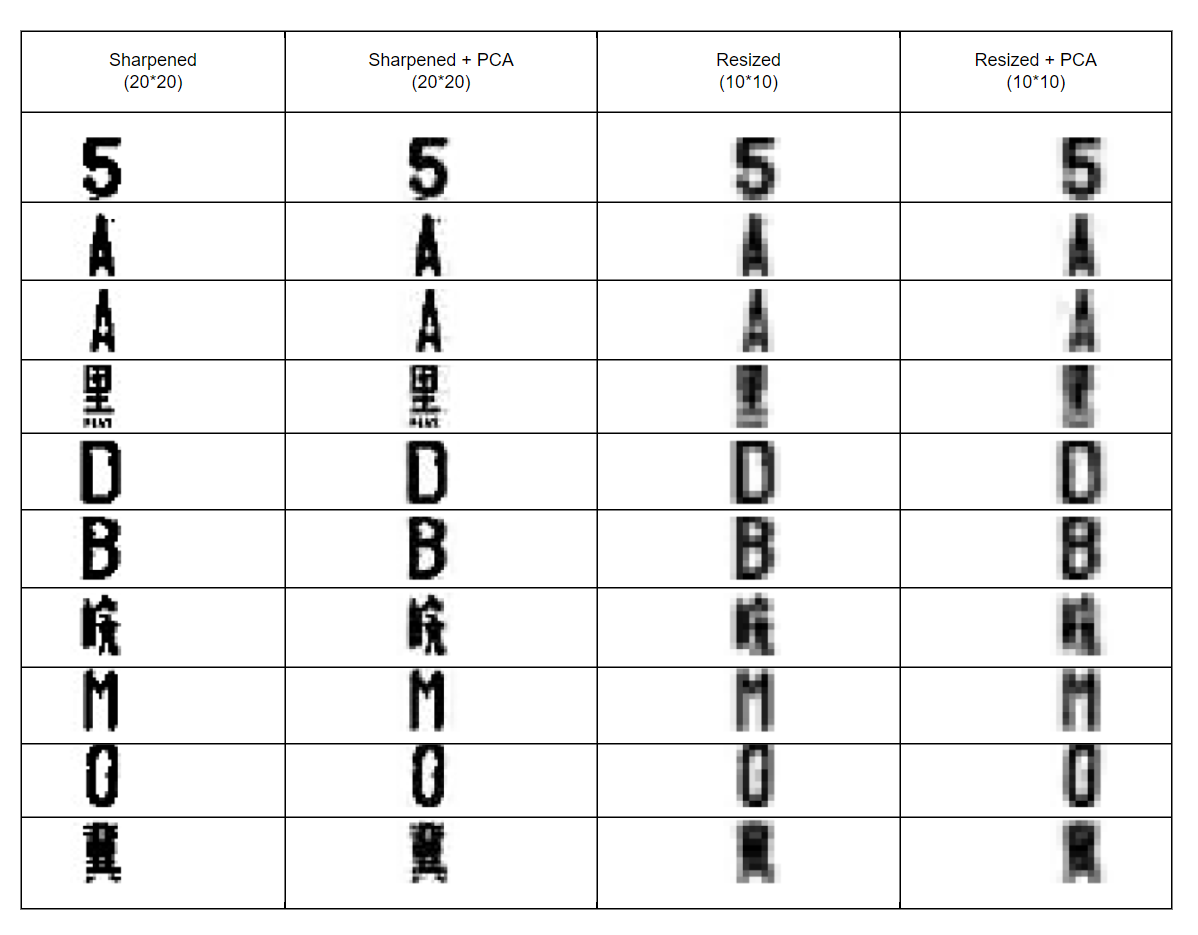  

As we can see, dimensionality reduction on sharpened (but not resized) images gives a promising compression result. Complicated images are blurred a bit, but still recognizable.  

As for dimensionality reduction on resized images (from $20*20$ to $10*10$), simple images such as "5", "D", still keep essential structures. However, the compressed images for complicated images are almost inrecognizable, as before PCA it is already blurry due to resize.  

In the later stage, we will test Knn on 4 different data set: sharpened, sharpened+PCA, resized, resize+PCA.  
An initial guess is, resize+PCA may have the fastest speed but lowest accuracy.

## 3. Knn

Euclidean distance, Chebyshev, minkowski(change  𝜆), weighted Euclidean distance

### 3-1. Cross Validation on Train Set

In [ ]:
k_values = [1, 3, 5, 7, 9, 11, 15, 19, 23]
metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
weights = ["uniform", "distance"]
x_trains = [sharpen_train_x, resize_train_x, X_reduced, X_reduced_resize]
x_train_names = ["Sharpened", "Sharpened+PCA", "Resized", "Resized+PCA"]


for i in range(0, len(x_trains)):
    print("Train set is: {}".format(x_train_names[i]))
    
    for weight in weights:
        for metric in metrics:
            print("Distance metrix: {}, Weight: {}".format(weight, metric))
            accuracy_scores = []
            for k in k_values:
                # construct knn classifier
                knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
                # cross validation
                cross_val_accuracies = cross_val_score(knn, x_trains[i], raw_train_y, cv=5)
                accuracy_scores.append(np.mean(cross_val_accuracies))
            print("Cross Validation Accuracy: {}".format(str(accuracy_scores)))
                

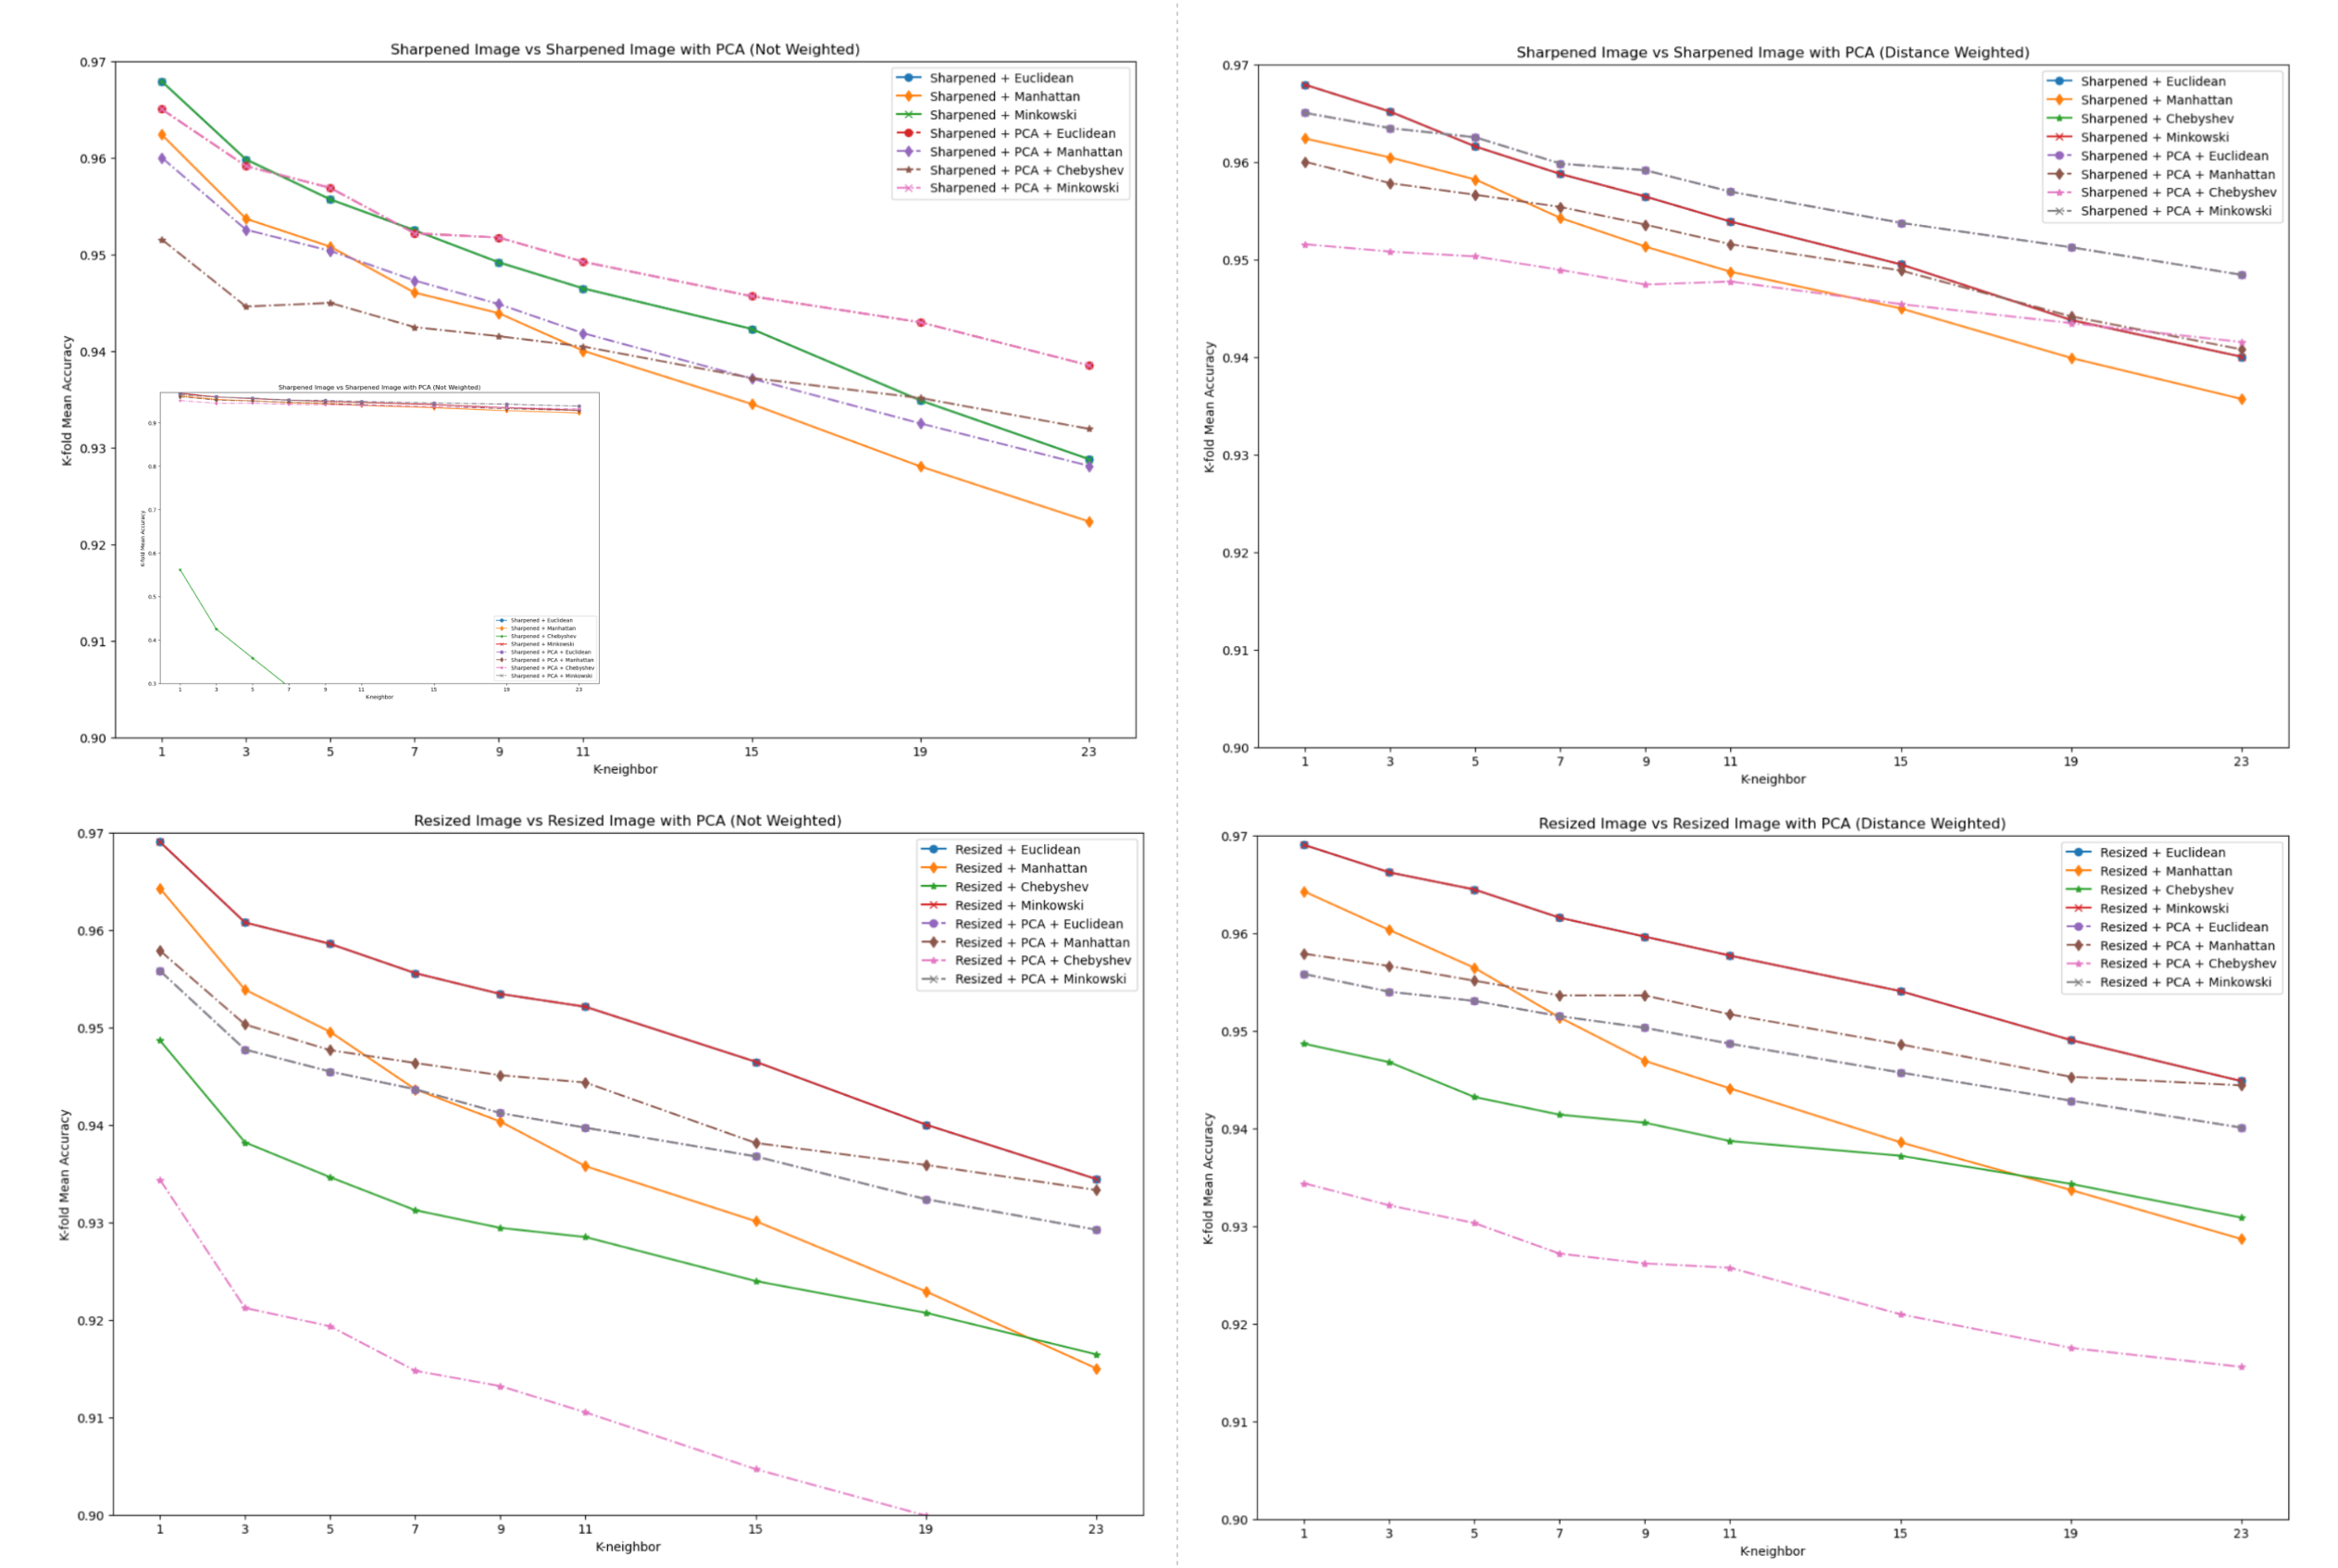

#### Observations

<mark>Image 1(top left): Non-Weighted</mark>   
Performances on sharpened images with euclidean and minkowski are the same. Performances of euclidean and minkowski on sharpened images with PCA compression are the same. Also, euclidean and minkowski behaves the best.
Manhattan on sharpened images is initially slightly better than on compressed images. As the k grows up to 3, performance on sharpened image set gets worse than on compression ones. 
In the smaller image, the worst behavior(green line) is from Chebyshev on sharpened images. 

<mark>Image 2(top right): Weighted</mark>   
Compared to Image1, weighted performances are better than non-weighted. To explain this conclusion, highest scores(in Image2) are a bit higher than in Image1, and the lowest scores in Image2 are much higher. Besides, the overall downward trend for accuracy scores with weighted calculation is much smoother.  
Minkowski and euclidean still behaves the same. Weighted Chebyshev on PCA is much better than non-weighted. However, it is still the worst performance.  
An interesting fact is Chebyshev and Euclidean overlaps.  
Chebyshev gives out the relatively poorest results. However, weighted Chebyshev's behaviour on PCA-compressed sharpened image is more stable, by comparing the slopes of the accuracy curves from Image1 and Image2.  

<mark>Image 3(bottom left): Non-Weighted</mark>   
Chebyshev still produces the lowest accuracy, and its downward trend is sharp.   
Except Manhattan, behaviors of the same distance metrics on resized images are better than on resized ones with PCA compression. This is perhaps because the compression does not sufficiently maintained enough image structures.  
Manhattan on resized images is at first better than on compressed resized images. When k reaches to 5, accuracies on compressed images get slightly better. Manhattan is the sum distance between two data points in a grid-like path. Although compression on PCA has caused key structure loss(Section 2.4), by increasing the neighbors amount, more "correct" sample points participate in the vote, as differeces from all dimensions add up, and, distances between "similar but incorrect ones" get evened out by "correct" ones.  


<mark>Image 4(bottom right): Weighted</mark>  
All curves have similar trends and ranks as non-weighted(Image3), though the accuracy is higher than without weighted.  

It is interesting that non-weighted performances of Euclidean and Minkowski on the same process image set are always the same. This rule also stands for weighted performances.We will test if this remains the same on test set.  
We will also investigate if chebyshev still behaves the worst.  
Manhattan always ranked in top three performances. We will also test this.

### 3.2 Test Set with Raw Images

In [16]:
# shuffle train set
def shuffle_data(features, label):
    temp = list(zip(features, label))
    random.shuffle(temp)
    features, label = zip(*temp)
    # res1 and res2 come out as tuples, and so must be converted to lists.
    features, label = list(features), list(label)
    return features, label

In [82]:
raw_train_x1, raw_train_y1 = shuffle_data(raw_train_x, raw_train_y)

In [ ]:
k_values = [1, 3, 5, 7, 9]
metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]
weights = ["uniform", "distance"]

for weight in weights:
    for metric in metrics:
        print("Distance metrix: {}, Weight: {}".format(weight, metric))
        accuracy_scores = []
        time_spent = []
        for k in k_values:
            print("k: {}".format(k))
            # construct knn classifier
            knn = KNeighborsClassifier(n_neighbors=k, weights=weight, metric=metric)
            # time the fit process
            start = time.time()
            knn.fit(raw_train_x1, raw_train_y1)
            y_pred = knn.predict(raw_test_x)
            stop = time.time()

            time_spent.append(stop-start)
            accuracy_scores.append(accuracy_score(raw_test_y, y_pred))
        
        print("Time spent is {}".format(time_spent))
        print("Accuracy is {}".format(accuracy_scores))

### 3.3 Test Set with Processed Images

In [80]:
# below codes are the same for testing sharpened/resized images with PCA compression

# step 1 read image
resize_train_x, resize_train_y = data_from_processed_image(train_data_path, resize=True)
resize_test_x, resize_test_y = data_from_processed_image(test_data_path, resize=True)

# step2 pca
pca = PCA()
pca.fit(sharpen_train_x)
# get the dimension by a simple fir
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# step3 fit
pca = PCA(n_components=d)
pca.fit(sharpen_train_x)
reduce_train_x = pca.transform(sharpen_train_x)
reduce_test_x = pca.transform(sharpen_test_x)

reduce_train_x1, reduce_train_y1 = shuffle_data(reduce_train_x, sharpen_train_y)

reduce_train_x.shape, reduce_test_x.shape

((15954, 146), (4665, 146))

### 3.4 Observations

#### Accuracy Scores
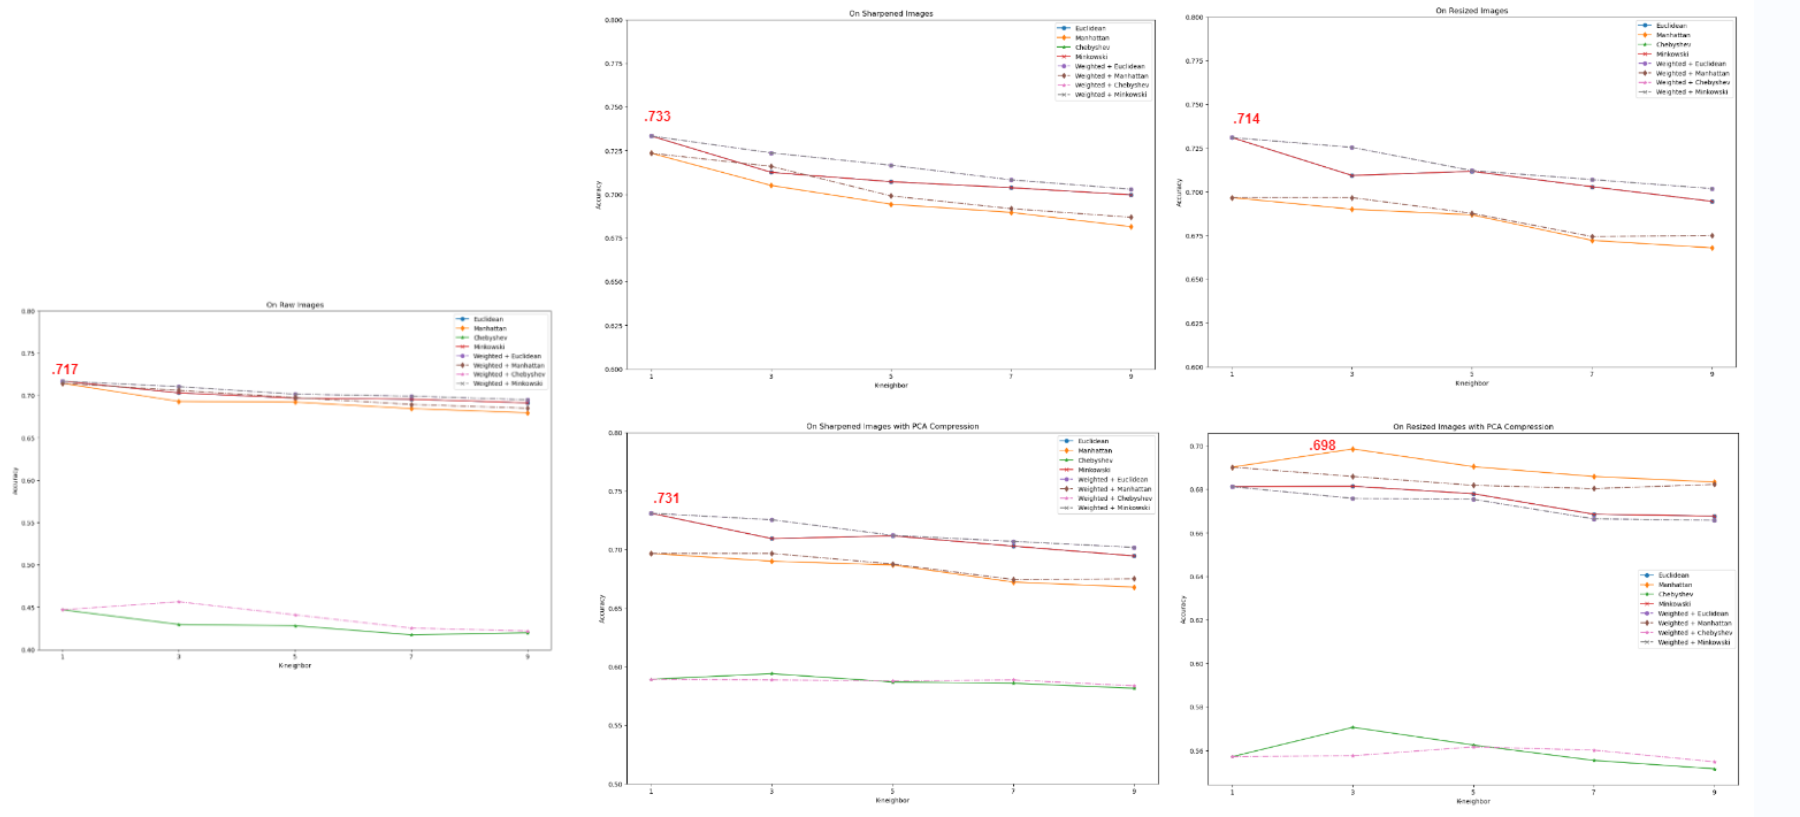

#### Time Spent
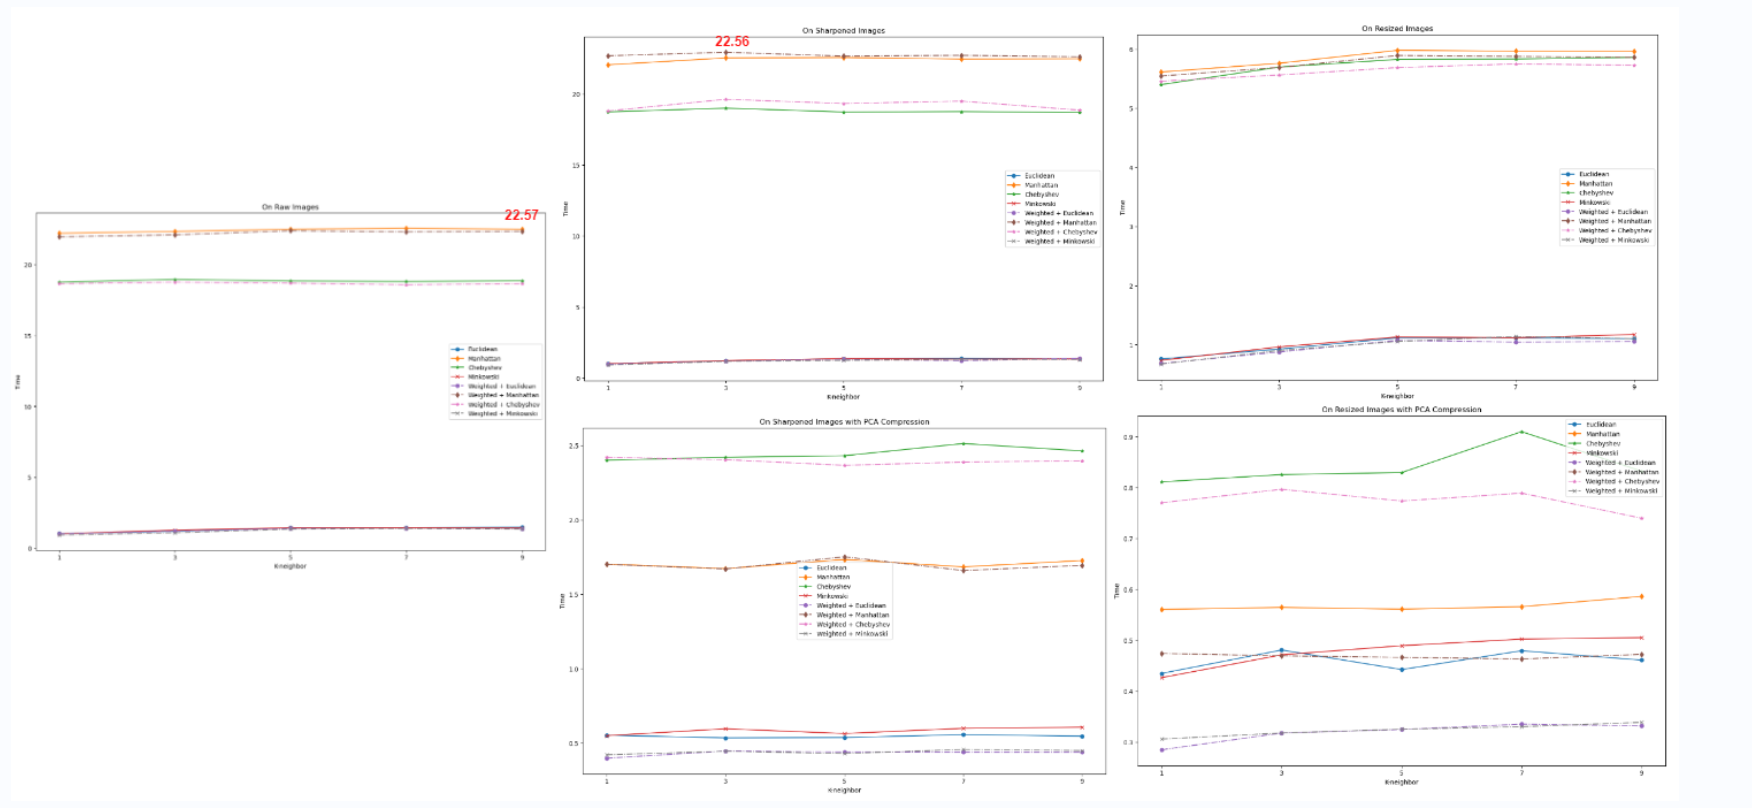

1. Chebyshev and Manhattan are expensive. Chebyshev has the lowest accuracy on this data set.
2. Accuracy scores generally follow a downward trend as the neighbor amount increases.
3. Time spent increases while the neighbor amount grows up.
4. Without any resizing or dimensionality reduction, that is 400-pixel values for each sample point, time spent with different distance calculation methods is similar.
5. Performances on test set prove the guess in Section 2.4. Resized images with PCA compression may have the fastest speed (time spent all below 1 sec) but lowest accuracy(peak is below 0.7). Details that form the key structures for identifying the image content are lost.
6. Under the same weighted method, Euclidean and Minkowski still have the same accuracy, and Minkowski takes slighty a bit more time to run.
7. Best accuracy score reaches 0.7333.
8. Weighted Knn has better accuracy than non-weighted ones.
9. In general, the cheapest and best combination is to run distance weighted knn with Minkowski distance on sharpened images.
10. Although Manhattan distance should behave better than Eucliean distance with high-dimension data, our graph suggests the other way around. This is potentially because Manhattan is usually used to deal with linear regression or data with linearity.
11. [ref: https://www.quora.com/What-are-pros-and-cons-of-using-Chebyshev-theorem] Chebyshev never provides a sharp bound on the probability. This is perhaps why Chenyshev has the worst performance here.

## 4. Impact From Train Set Amount
We will take sharpened images, sharpened images with PCA and resized images for testing. Knn weighted by distance will be used in this section, as in the pevious section, weighted performs better than non-weighted ones.

In [78]:
proportions = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
RANDOM_SEED = 2020 # random seed from sample code
k_values = [1, 3, 5, 7, 9]
metrics = ["euclidean", "manhattan", "chebyshev", "minkowski"]

In [ ]:
# sharpened images
for amount in proportions:
    if amount != 1.0:
        x_res, x_train, y_res, y_train = train_test_split(reduce_train_x, sharpen_train_y, test_size=amount, random_state=RANDOM_SEED)
        train_x1, train_y1 = shuffle_data(x_train, y_train)
    else:
        train_x1, train_y1 = shuffle_data(reduce_train_x, sharpen_train_y)
    
    for metric in metrics:
        print("Train Set Amount: {}, Distance metrix: {}".format(amount, metric))
        accuracy_scores = []
        time_spent = []
        for k in k_values:
            # construct knn classifier
            knn = KNeighborsClassifier(n_neighbors=k, weights="distance", metric=metric)
            # time the fit process
            start = time.time()
            knn.fit(train_x1, train_y1)
            y_pred = knn.predict(reduce_test_x)
            print(y_pred.shape)
            stop = time.time()

            time_spent.append(stop-start)
            accuracy_scores.append(accuracy_score(sharpen_test_y, y_pred))

        print("Time spent is {}".format(time_spent))
        print("Accuracy is {}".format(accuracy_scores))

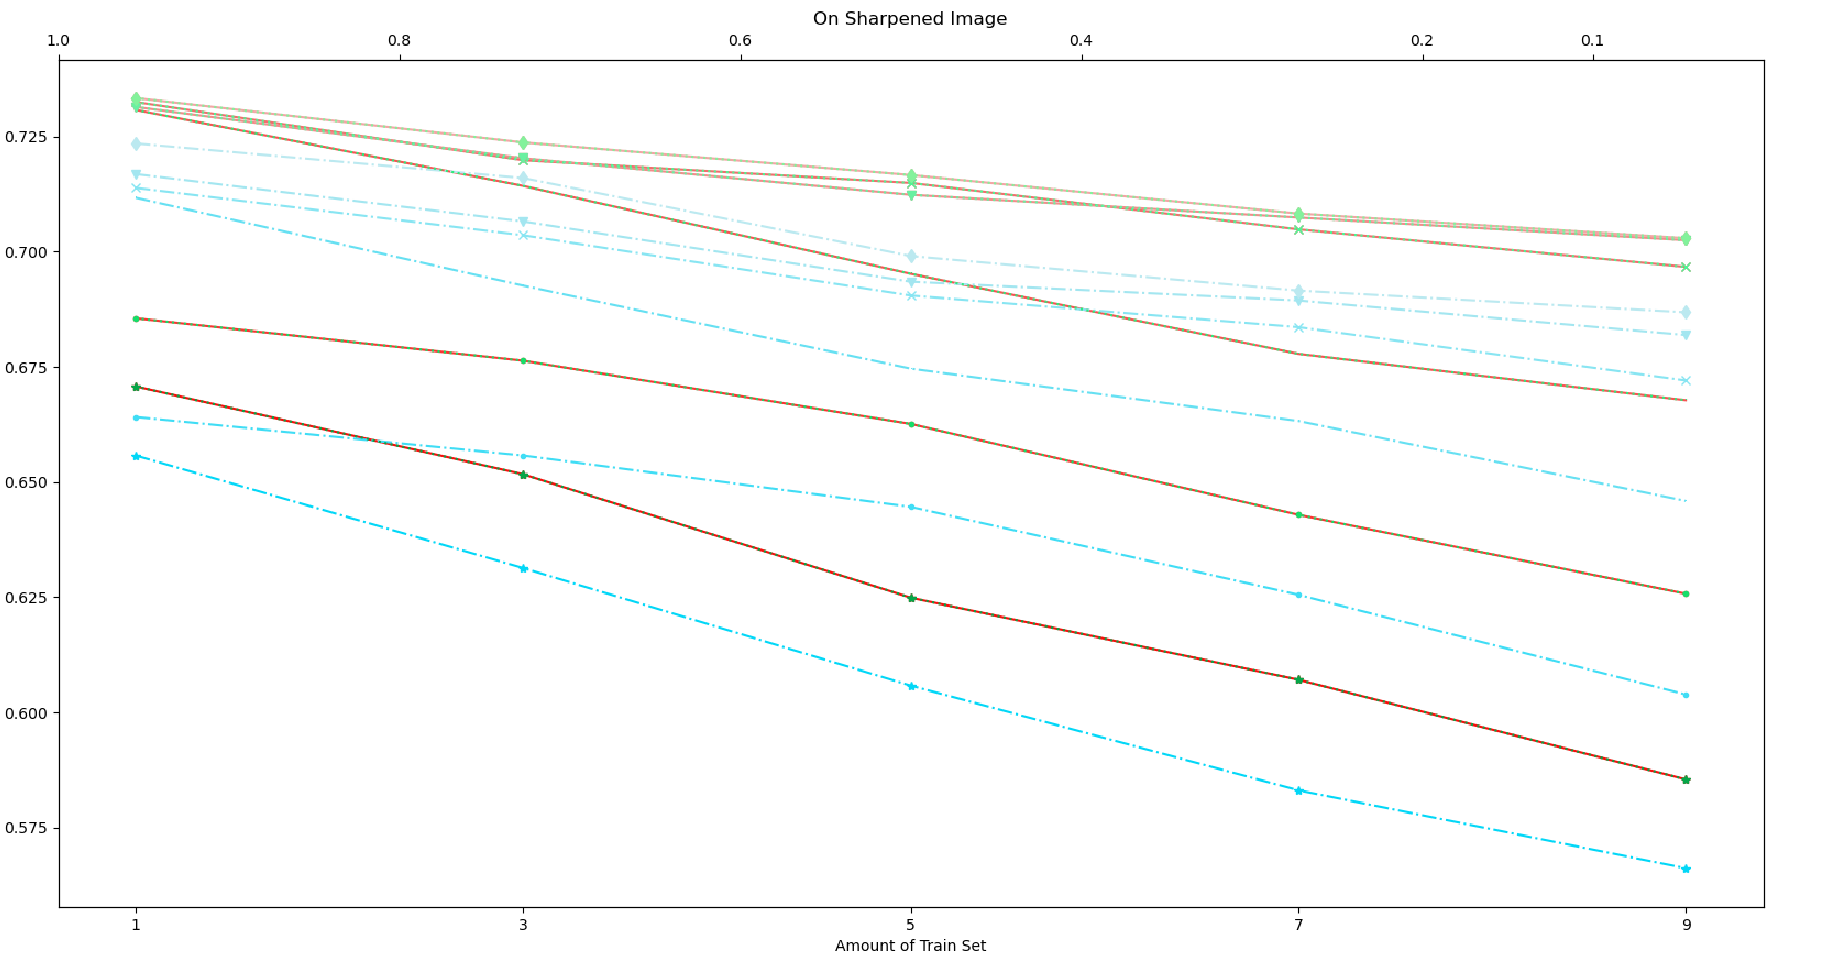
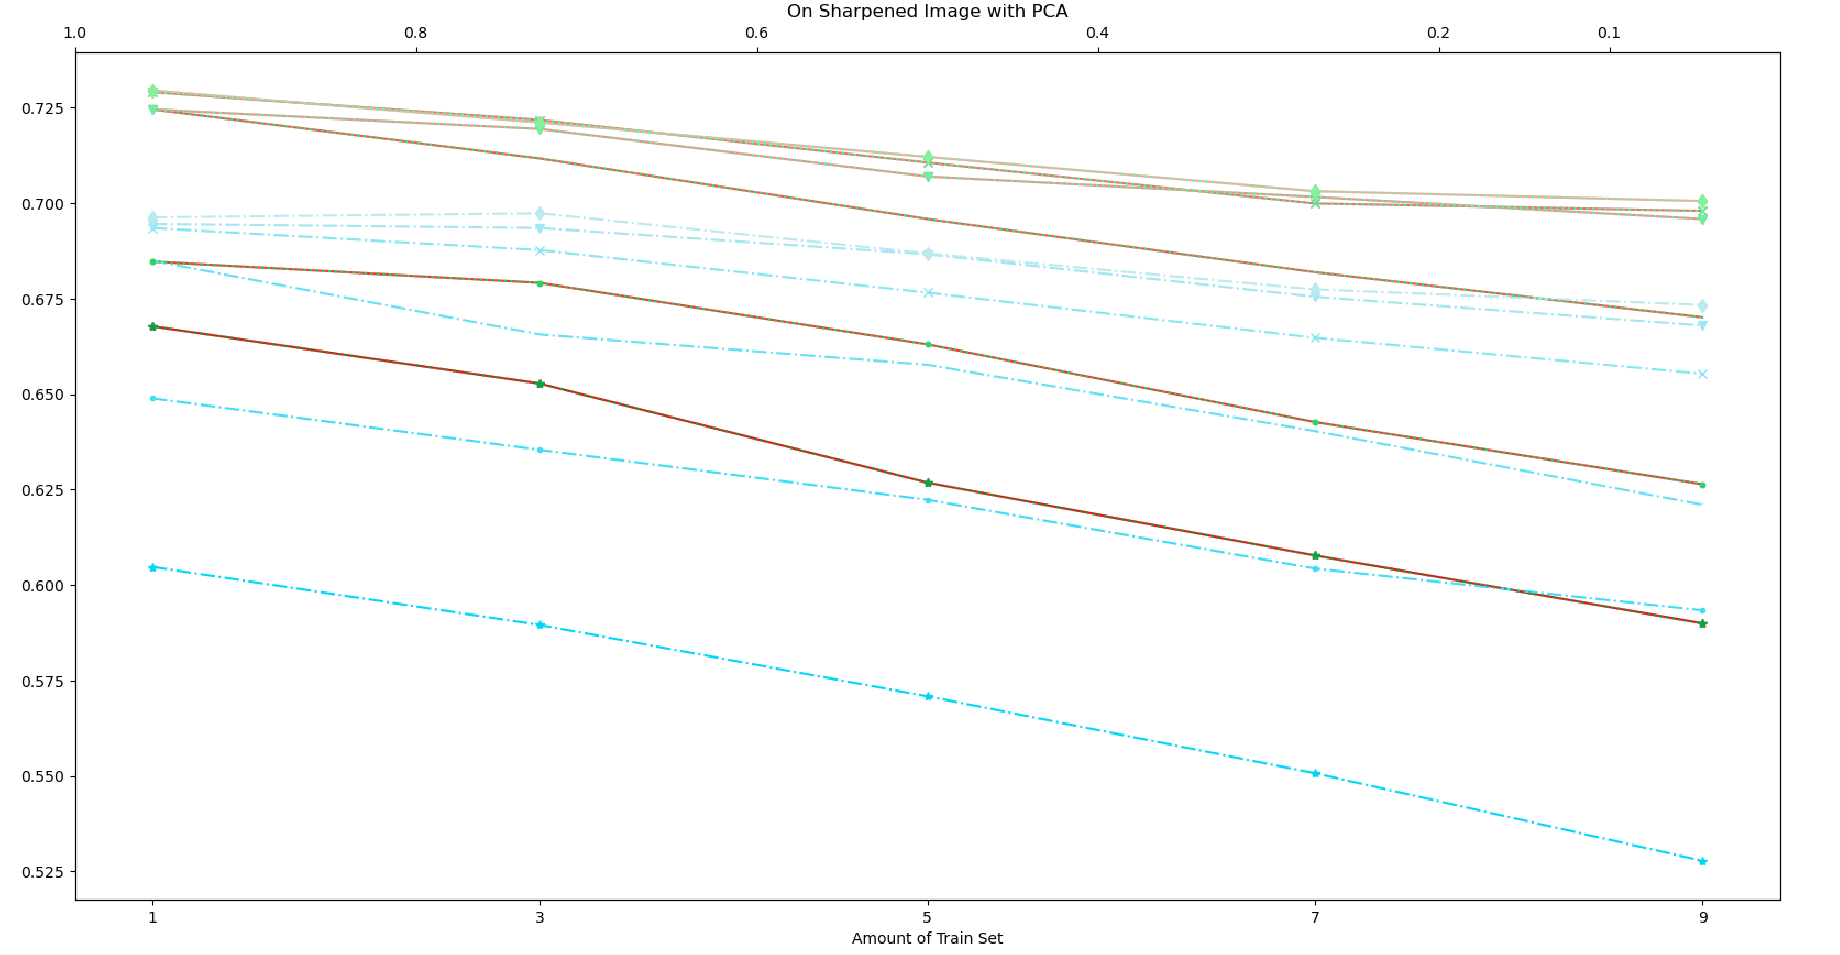
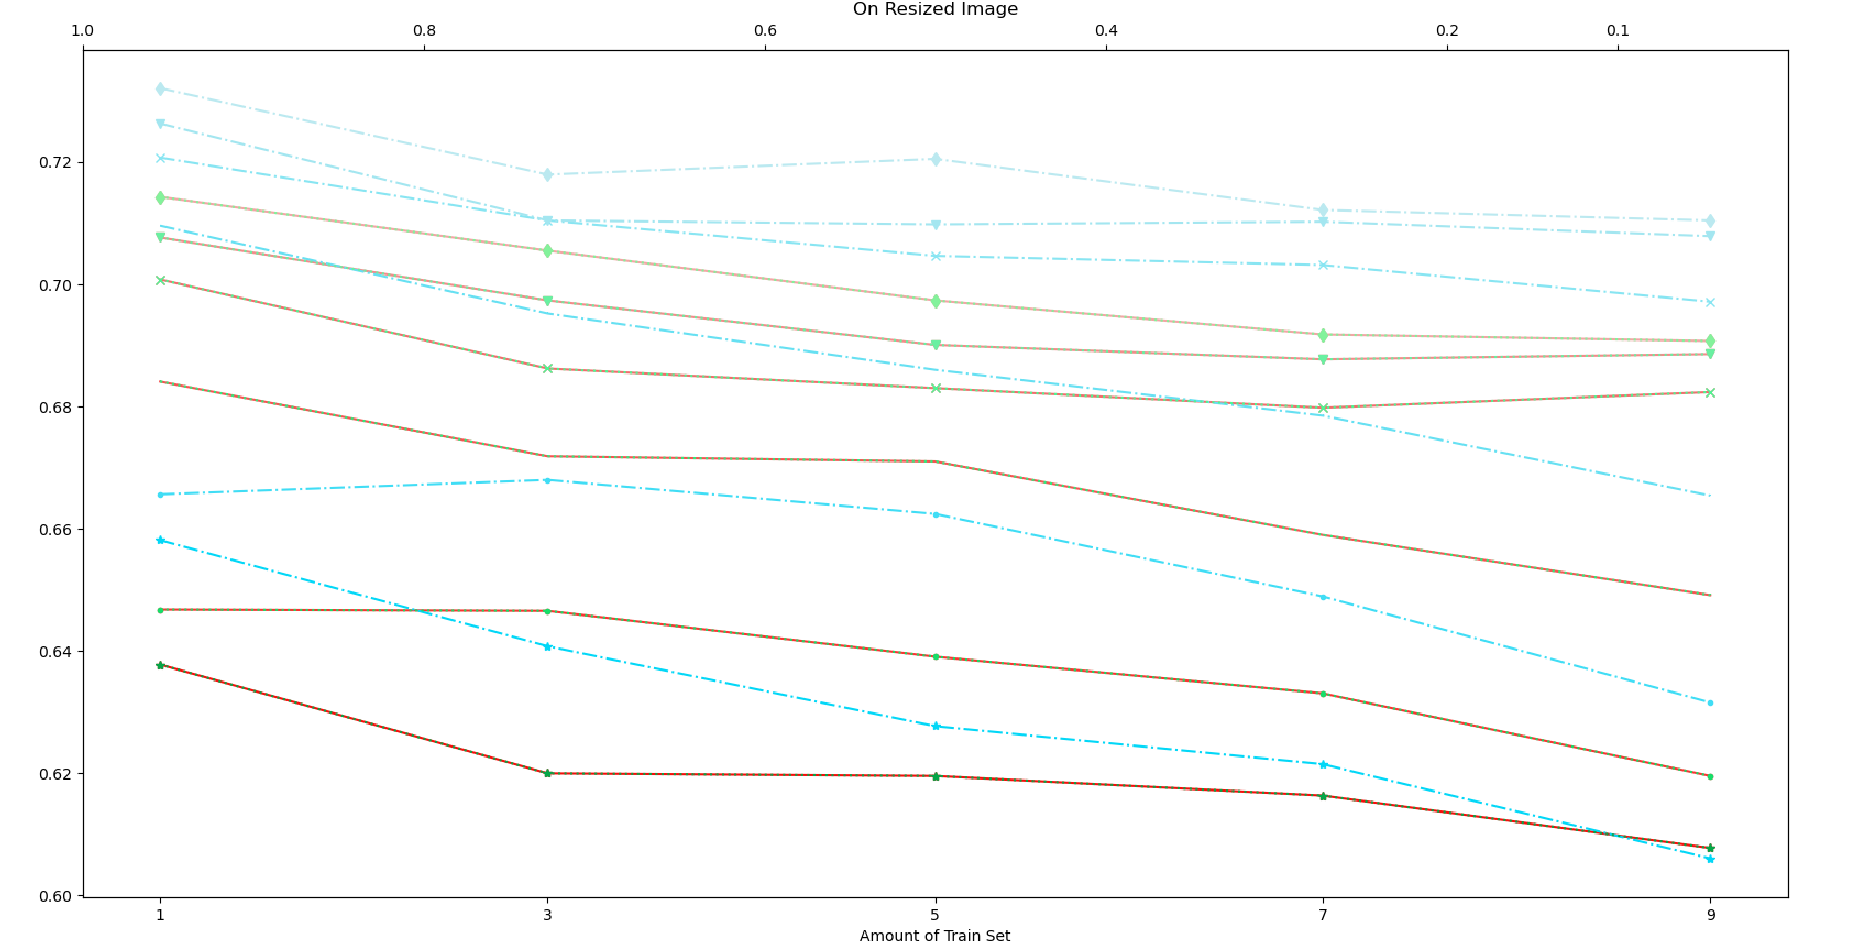


The upper X axis is the amount of data we take from the original train set to form the new train set.  
Red lines: Euclidean    
Blue lines: Manhattan  
Green lines: Minkowski   

#### Observation
1. Accuracy grows as the train set becomes larger. Accuracy on the same data set drops as the neighbor amount increases.
2. The highest accuracy on sharpened images reaches 0.733 on sharpened images, with PCA compression the accuracy slightly decreases to 0.729.
3. Regardless the train set amount, Euclidean and Minkowski distance still behave the same.
4. On sharpened images (with and without PCA), Minkowski and Euclidean still are the best performing algorithm; Exception happens on the resized images, on which Manhattan distance carries out the best accuracy. Manhattan works better if (1) every dimension is of equal importance, (2) linear relationship exists between dimensions. Although situation(1) may be the true case for our data, (2) is unclear. This might be the reason why it does not behave as well as the other distance methods. Also due to this, without resizing the images to much smaller-dimensional samples, we can presume that "the more features we have then the more data we need to train a good model. Expanding on this, if you have a fixed amount of training data (which is often the case) your model's accuracy will decrease for every feature you have." That is perhaps why Manhattan behaves better on resized images, as we limit the feature we have.
5. Chebyshev still behaves the worst(not showing on the graph). Online forum mentioned that Chebyshev is extremely useful when measuring the distance between images. However, it is not what the data suggests here. One of the reasons may be that Chebyshev are used to detect similarity between images on extracted features, rather than pixels. 

## 5. Knn and Regression

ref: https://www.geeksforgeeks.org/locally-weighted-linear-regression-using-python/  

Locally weighted linear regression is the nonparametric regression methods that combine k-nearest neighbor based machine learning. It is referred to as locally weighted because for a query point the function is approximated on the basis of data near that and weighted because the contribution is weighted by its distance from the query point.    

ref: https://stackoverflow.com/questions/33852388/rbf-kernel-for-classification-using-knn  
ref: https://stackoverflow.com/questions/48914360/what-is-the-kernel-for-the-knn-regressor-in-sklearn-python  
ref: https://stackoverflow.com/questions/62844914/nearest-neighbor-using-customized-weights-on-python-scikit-learn  

In [13]:
def evaluate_prediction(y_predict, y_test):
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.power(mse, 0.5)
    r2 = r2_score(y_test, y_predict)
    print("MSE is: {}".format(mse))
    print("RMSE is: {}".format(rmse))
    print("R2 is: {}".format(r2))

In [7]:
sigma_values = [1/2, 1/4, 1/8, 1/16, 1/32]
k_values = [3, 5, 7, 9, 15, 19, 25]
metrics = ["minkowski"]

In [60]:
# convert from list to nop.array and cast all to float64 for regression to work
sharpen_train_x1 = np.array(sharpen_train_x, dtype='float64')
sharpen_train_y1 = np.array(sharpen_train_y, dtype='float64')
sharpen_test_x1 = np.array(sharpen_test_x, dtype='float64')
sharpen_test_y1 = np.array(sharpen_test_y, dtype='float64')

# normalize x sets
sharpen_train_x1  = (sharpen_train_x1 - np.min(sharpen_train_x1))/np.ptp(sharpen_train_x1)
sharpen_test_x1  = (sharpen_test_x1 - np.min(sharpen_test_x1))/np.ptp(sharpen_test_x1)

sharpen_train_x1.shape, sharpen_train_y1.shape, sharpen_test_x1.shape

((15954, 400), (15954,), (4665, 400))

In [117]:
def gaussian(dist):
    # if user attempts to classify a point that was zero distance from one
    # or more training points, those training points are weighted as 1.0
    # and the other points as 0.0
    sigma = 1/32
    dist = normalize(dist)
    if dist.dtype is np.dtype(object):
        for point_dist_i, point_dist in enumerate(dist):
            # check if point_dist is iterable
            # (ex: RadiusNeighborClassifier.predict may set an element of
            # dist to 1e-6 to represent an 'outlier')
            if hasattr(point_dist, "__contains__") and 0.0 in point_dist:
                dist[point_dist_i] = point_dist == 0.0
            else:
                dist[point_dist_i] = np.exp(-np.square(point_dist)/np.square(sigma))
    else:
        with np.errstate(divide="ignore"):
            dist = np.exp(-np.square(dist)/np.square(sigma))
        inf_mask = np.isinf(dist)
        inf_row = np.any(inf_mask, axis=1)
        dist[inf_row] = inf_mask[inf_row]
    return dist


In [102]:
model = KNeighborsRegressor(n_neighbors=9, weights=gaussian, metric="euclidean")

model.fit(sharpen_train_x1, sharpen_train_y1)
y_pred = model.predict(sharpen_test_x1)
evaluate_prediction(y_pred, sharpen_test_y1)

MSE is: 77.03218386224177
RMSE is: 8.77679804155489
R2 is: 0.4682632313989987


In [125]:
for metric in metrics:
    print("Gaussian sigma: {}, Weight: {}".format(1/32, metric))
    RMSE_scores = []
    R2_scores = []
    time_spent = []
    
    for k in k_values:
        print("k: {}".format(k))
        # construct knn classifier
        model = KNeighborsRegressor(n_neighbors=k, weights=gaussian, metric=metric)
        # time the fit process
        start = time.time()
        model.fit(sharpen_train_x1, sharpen_train_y1)
        y_pred = model.predict(sharpen_test_x1)
        stop = time.time()

        time_spent.append(stop-start)
        RMSE_scores.append(np.power(mean_squared_error(sharpen_test_y1, y_pred), 0.5))
        R2_scores.append(r2_score(sharpen_test_y1, y_pred))

    print("Time spent is {}".format(time_spent))
    print("RMSE is {}".format(RMSE_scores))
    print("R2 is {}".format(R2_scores))

Gaussian sigma: 0.03125, Weight: minkowski
k: 3
k: 5
k: 7
k: 9
k: 15
k: 19
k: 25
Time spent is [0.49863457679748535, 0.5146257877349854, 0.5216045379638672, 0.5315804481506348, 0.517615795135498, 0.5495307445526123, 0.5624969005584717]
RMSE is [9.030304145605207, 8.952494717367486, 8.867180405715846, 8.77679804155489, 8.482340644033513, 8.28015327741911, 7.985768947993106]
R2 is [0.4371026068494096, 0.44676120266520536, 0.4572553257762393, 0.4682632313989987, 0.5033437552211042, 0.5267384363944569, 0.5597919674428482]


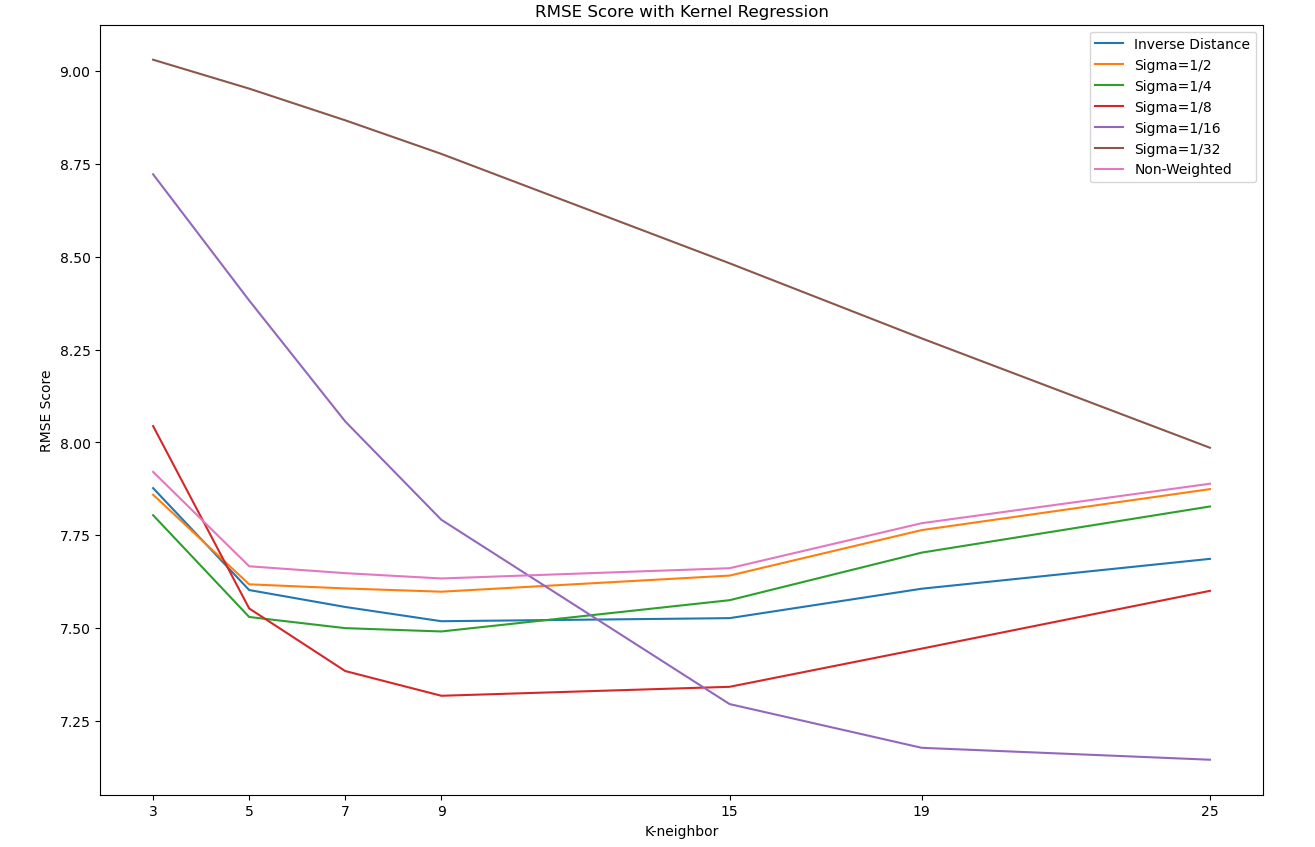
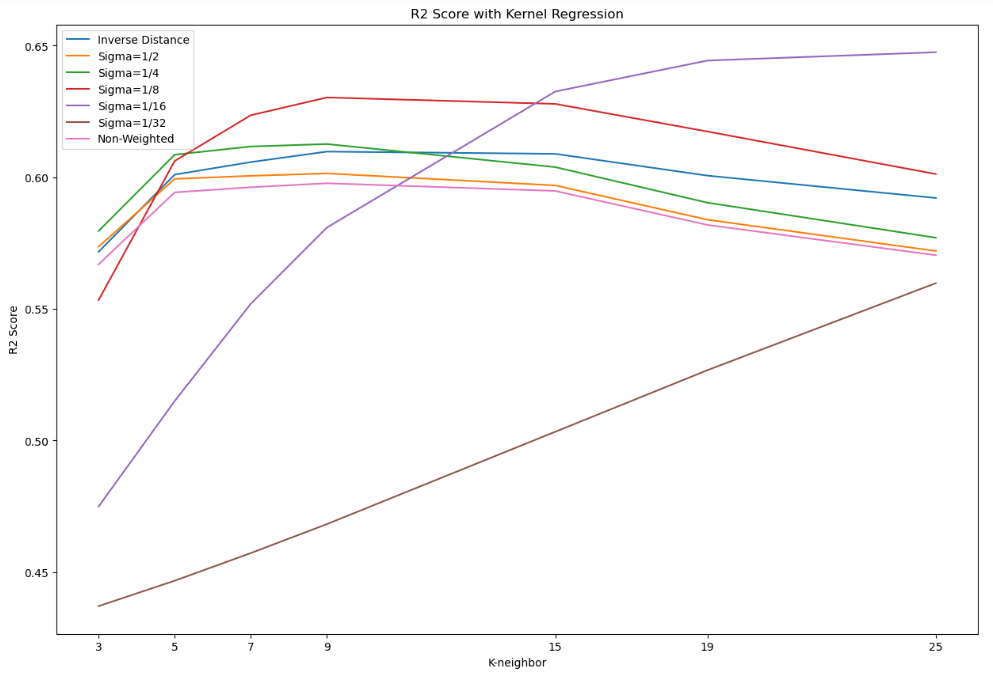

#### Observation

1. RMSE and R2 scores have negative correlation. High R2 and low RMSE are what a good model should have.  

2. Best regression result is K-nearest neighbors regression with Gaussian sigma = 1/16, neighbor amount k=25. The R2 score under this situation reaches about 0.65. So, the model's interpretability is not good enough. This might be improved by changing the base function for getting weights from distance; Or, this data model is not suitable to be processed by K-nearest neighbors regression.  

3. Non-weighted(uniform) K-nearest neighbors regression has the bottom 3 R2 scores. It is fair to say that distance-based weighted kernel regression performs better than non-weighted.  

4. When sigma gets close to 1, the weights are more expanded, which suggests that more information is aggregated from farther samples. That is the reason R2 scores grow up while sigma decreases. When sigma reaches 1/32, there is a sharp drop on model behaviors. This is where overfitting happens.  

5. When the neighbor amount is small (k below 7), high Gaussian sigma has better R2 scores. This is because we have limited samples to interpolate, and to avoid underfitting, we need to aggregate as more information as we can


## Summary

We experimented K-NN with Euclidean, Manhattan, Chebyshev and Minkowski distances. The best
accuracy so far is 0.733 by running distance-weighted K-NN on sharpened images, with neighbor amount
set to 1 and distance set to Euclidean/Minkowski.  

PCA dimensionality reduction could sufficiently reduce the learning time spent, however, at the same
time, decrease the prediction accuracy.  

K-NN performances can also be affected by the train set amount. On images that haven't been
downscaled, the more samples we have in the train set, the better the accuracy we can get.  

On the same image data set, Euclidean and Minkowski behave the same. Manhattan behaves better on
downscaled images Chebyshev has the worst performances. One of the reasons may be that Chebyshev
is used to detect similarity between images on extracted features, rather than directly comparing pixels.
For expansion, we also test distance-weighted K-Nearest Neighbor Regression with Gaussian kernel as
the base function. Best result is K-nearest neighbors regression with Gaussian sigma = 1/16, neighbor
amount k=25. The R2 score under this situation reaches about 0.65. So, the model's interpretability is not
good enough. This might be improved by changing the base function for getting weights from distance;
Or, this data model is not suitable to be processed by K-nearest neighbors regression.  

Overall, neither K-NN or K-Nearest Neighbor Regression can have accuracy scores more than 0.75, so
we could not say we build a model with good precision and interpretability over the data we have. The
issue is that the task is in fact a pattern recognition. Only comparing pixel values(colors) does not
consider pattern size and transforming(e.g shearing due to perspective) . To improve the model, we
should extract pattern features instead.